---

This notebook will recreate Dr. Davila's research paper, [Estimating the stability number of a random graph using convolutional neural networks](http://arxiv.org/pdf/2407.07827), but will instead use CNNs to predict the domination number of a graph. We will make use of the graphcalc library to streamline parts of the code, since it contains functions to perform many of the necessary computations on graphs.

---

In [8]:
# Import necessary packages:
import graphcalc as gc
import networkx as nx
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models
from PIL import Image
from keras.models import Model
import random
import time
from itertools import combinations
from pulp import LpBinary, LpMaximize, LpMinimize, LpProblem, LpVariable, lpSum

In [9]:
# Function to convert adjacency matrix and heatmap to fixed-size image.
def convert_to_heatmap_image(G, target_size=64):
    adj_matrix = nx.to_numpy_array(G)
    matrix_size = adj_matrix.shape[0]

    if matrix_size < target_size:
        padded_matrix = np.zeros((target_size, target_size), dtype=int)
        padded_matrix[:matrix_size, :matrix_size] = adj_matrix
    elif matrix_size > target_size:
        image = Image.fromarray(adj_matrix)
        padded_matrix = np.array(image.resize((target_size, target_size), Image.BILINEAR))
    else:
        padded_matrix = adj_matrix

    degree_dict = dict(G.degree())
    degrees = np.array([degree_dict[node] for node in G.nodes()])
    heatmap = np.zeros((target_size, target_size), dtype=float)

    for i, node in enumerate(G.nodes()):
        if i < target_size:
            heatmap[i, i] = degrees[i]

    combined_matrix = padded_matrix + heatmap
    combined_image = (combined_matrix / combined_matrix.max() * 255).astype(np.uint8)

    return Image.fromarray(combined_image, 'L')

# Function to generate random graphs and calculate their domination number.
def generate_domination_number_data(num_graphs, max_nodes):
    graphs = []
    domination_numbers = []
    for _ in range(num_graphs):
        num_nodes = random.randint(5, max_nodes)
        G = nx.gnp_random_graph(num_nodes, np.random.rand())
        ind_num = gc.domination_number(G)
        graphs.append(G)
        domination_numbers.append(ind_num)
    return graphs, domination_numbers

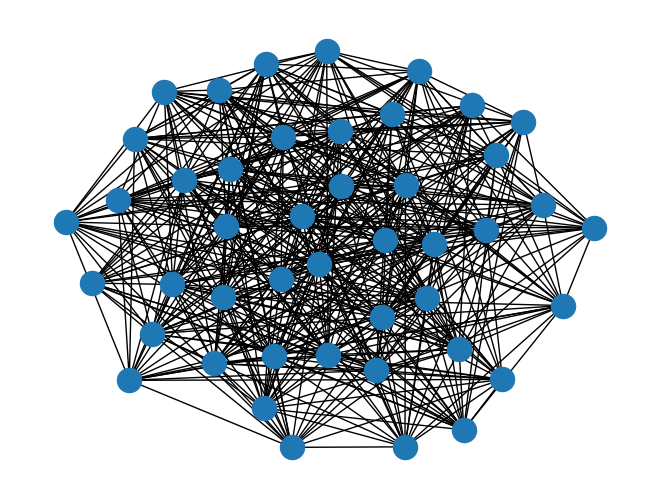

In [10]:
G = nx.gnp_random_graph(45, 0.5)
nx.draw(G)
plt.show()

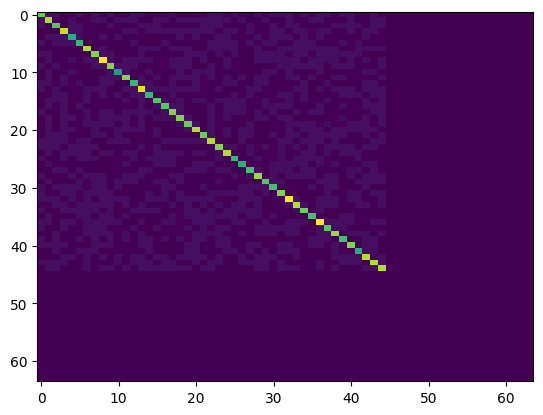

In [11]:
image = convert_to_heatmap_image(G)
plt.imshow(image, cmap='viridis', aspect='auto')
plt.show()

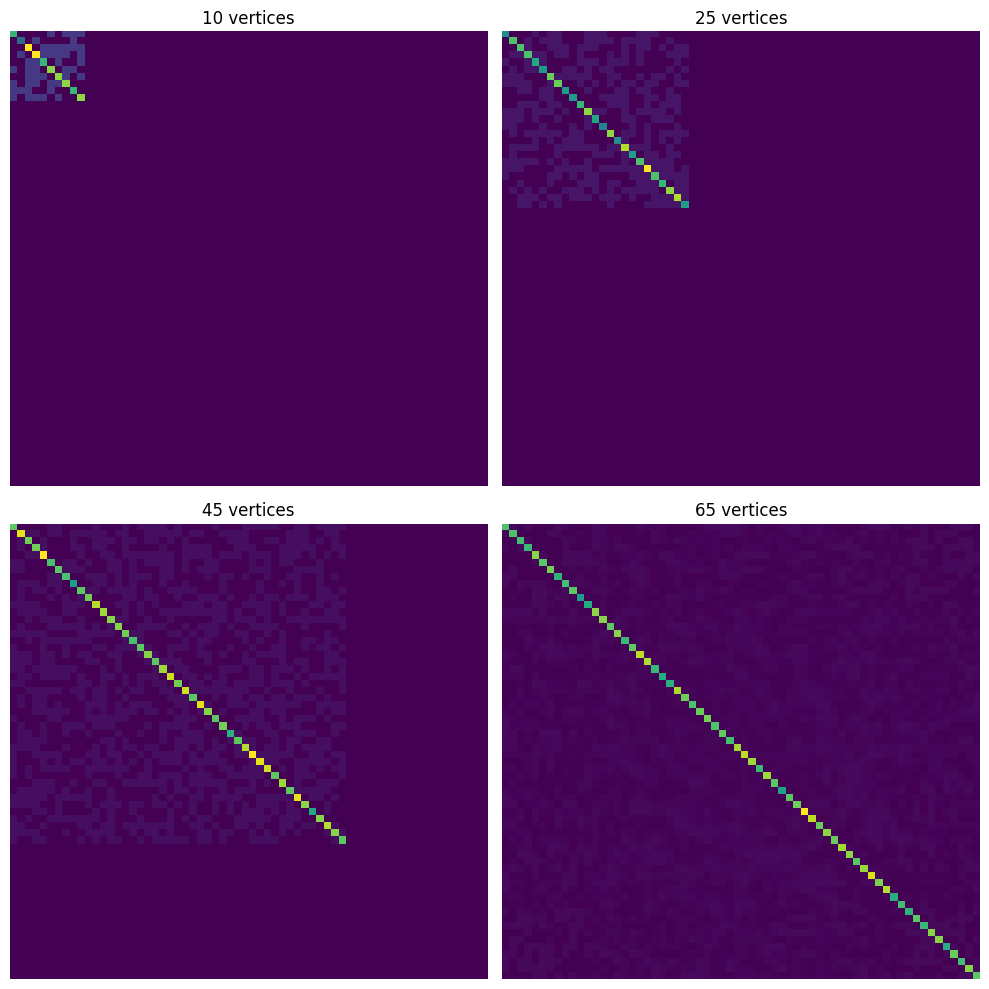

In [12]:
# Create graphs with different numbers of vertices
graphs = [
    nx.gnp_random_graph(10, 0.5),
    nx.gnp_random_graph(25, 0.5),
    nx.gnp_random_graph(45, 0.5),
    nx.gnp_random_graph(65, 0.5)
]

# Create a figure with 2x2 subplots
fig, axs = plt.subplots(2, 2, figsize=(10, 10))

# Titles for the subplots
titles = ['10 vertices', '25 vertices', '45 vertices', '65 vertices']

for i, (G, ax) in enumerate(zip(graphs, axs.flatten())):
    image = convert_to_heatmap_image(G)
    ax.imshow(image, cmap='viridis', aspect='auto')
    ax.set_title(titles[i])
    ax.axis('off')  # Hide the axes

plt.tight_layout()
plt.show()

In [ ]:
# Generate dataset of 2,000 random graphs with varying node sizes 10 <= n <= 64.
num_graphs = 2_000
max_nodes = 64
graphs, domination_numbers = generate_domination_number_data(num_graphs, max_nodes)

# Convert graphs to images.
target_size = 64
images = [convert_to_heatmap_image(graph, target_size) for graph in graphs]
X = np.array([np.array(image).reshape(target_size, target_size, 1) for image in images])
y = np.array(domination_numbers)

# Split dataset into training and testing.
split_index = int(0.8 * num_graphs)
X_train, X_test = X[:split_index], X[split_index:]
y_train, y_test = y[:split_index], y[split_index:]

In [ ]:
from tensorflow.keras import layers, models

# Define the CNN model.
def create_model(input_shape):
    model = models.Sequential()
    model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(layers.Flatten())
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(1))  # Output layer for regression

    model.compile(optimizer='adam',
                  loss='mean_squared_error',
                  metrics=['mae'])
    return model

# Instantiate and train the model.
input_shape = (target_size, target_size, 1)
model = create_model(input_shape)
model.summary()
history = model.fit(X_train, y_train, epochs=15, validation_split=0.2)

c:\Users\kylej\OneDrive\Documents\Schoolwork\Research\graphs\CNN-domination-number\venv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 62, 62, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 31, 31, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 29, 29, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 12, 12, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 9216)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │       589,888 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 645,697 (2.46 MB)

 Trainable params: 645,697 (2.46 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/15
40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 121.8873 - mae: 5.5515 - val_loss: 12.5993 - val_mae: 1.7134
Epoch 2/15
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 8.3005 - mae: 1.6923 - val_loss: 5.6242 - val_mae: 1.0691
Epoch 3/15
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 4.1256 - mae: 1.0716 - val_loss: 8.5939 - val_mae: 1.8945
Epoch 4/15
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 5.2016 - mae: 1.2151 - val_loss: 7.6550 - val_mae: 1.1457
Epoch 5/15
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 4.6353 - mae: 1.1249 - val_loss: 4.8593 - val_mae: 0.9019
Epoch 6/15
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 5.1856 - mae: 0.9097 - val_loss: 6.6093 - val_mae: 1.0715
Epoch 7/15
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 4.7009 - mae: 1.1713 - val_loss: 5.3680 - val_mae: 1.1133
Epoch 8/15
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 3.2619 - mae: 1.0540 - val_loss: 6.7934 - val_mae: 1.1180
Epoch 9/15
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 3.

In [ ]:
# Evaluate the model.
loss, mae = model.evaluate(X_test, y_test)
print(f'Test MAE: {mae}')

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1.5542 - mae: 0.6695 
Test MAE: 0.7040078043937683


In [ ]:
# Generate a random graph with n nodes.
n = 30
G = nx.gnp_random_graph(n, np.random.rand())

# Convert adjacency matrix to image with heatmap.
adj_image = convert_to_heatmap_image(G)

# Prepare the image for the model.
input_image = np.array(adj_image).reshape(1, 64, 64, 1)  # Add batch dimension and channel dimension.

# Predict the domination number using the trained CNN.
predicted_domination_number = model.predict(input_image)
print(f"Predicted domination number for the {n}-node graph: {predicted_domination_number[0][0]}")

# Compute the actual domination number using linear-integer programming for comparison.
actual_domination_number = gc.domination_number(G)
print(f"Computed domination number for the {n}-node graph: {actual_domination_number}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
Predicted domination number for the 30-node graph: 2.4367802143096924
Computed domination number for the 30-node graph: 2


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━

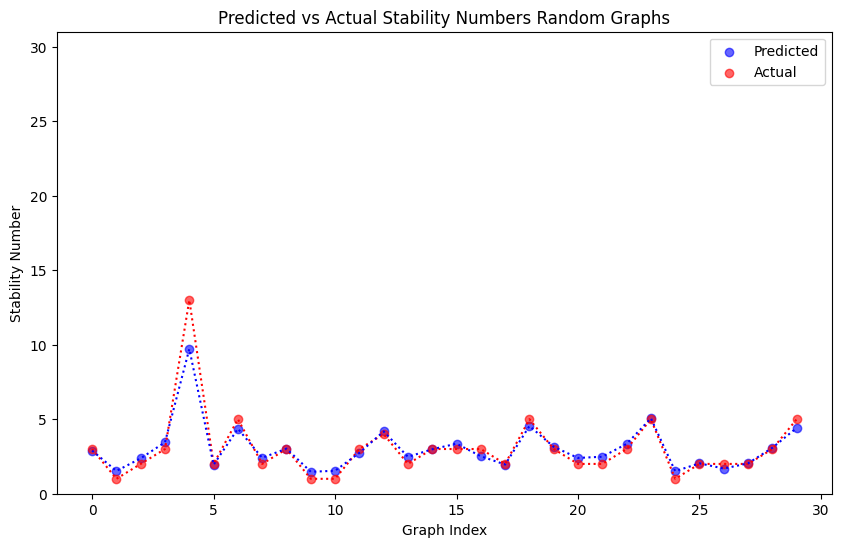

<Figure size 640x480 with 0 Axes>

In [ ]:
import pandas as pd
# Generate and process multiple random graphs
num_graphs = 30
num_nodes = 30
results = []

for _ in range(num_graphs):
    G = nx.gnp_random_graph(n, np.random.rand())

    # Convert adjacency matrix to image with heatmap
    adj_image = convert_to_heatmap_image(G)

    # Prepare the image for the model
    input_image = np.array(adj_image).reshape(1, 64, 64, 1)  # Add batch dimension and channel dimension

    # Predict the domination number using the trained CNN
    predicted_domination_number = model.predict(input_image)[0][0]

    # Compute the actual domination number
    actual_domination_number = gc.domination_number(G)

    # Store the results
    results.append({
        "Graph Index": _,
        "Predicted Domination Number": predicted_domination_number,
        "Actual Domination Number": actual_domination_number
    })

# Create a DataFrame to hold the results
results_df = pd.DataFrame(results)

# Display the results as a table
print(results_df)

# Plot the results as a scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(results_df["Graph Index"], results_df["Predicted Domination Number"], label="Predicted", color='blue', alpha=0.6)
plt.scatter(results_df["Graph Index"], results_df["Actual Domination Number"], label="Actual", color='red', alpha=0.6)
plt.plot(results_df["Graph Index"], results_df["Actual Domination Number"], color='red', linestyle='dotted')
plt.plot(results_df["Graph Index"], results_df["Predicted Domination Number"], color='blue', linestyle='dotted')
plt.xlabel("Graph Index")
plt.ylabel("Stability Number")
plt.title("Predicted vs Actual Stability Numbers Random Graphs")
plt.ylim(0, num_nodes+1)
plt.legend()
plt.show()

# Optionally, save the figure
plt.savefig("stability_number_prediction_comparison.png")

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
Test MSE: 1.7236977815628052
Test MAE: 0.7040078043937683
Test RMSE: 1.312896713973649
Test R-squared: 0.9108559489250183
95% Confidence Interval for the Predictions: (np.float64(3.716644192115872), np.float64(4.46179017983237))


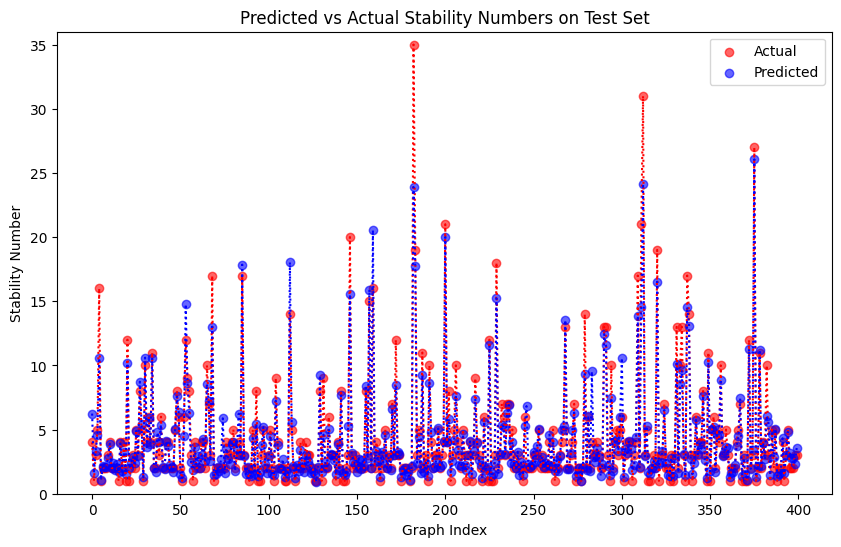

<Figure size 640x480 with 0 Axes>

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from scipy import stats

# Function to calculate RMSE
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

# Evaluate the model on the test set
y_pred = model.predict(X_test).flatten()

# Calculate evaluation metrics
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
rmse_val = rmse(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Print evaluation metrics
print(f'Test MSE: {mse}')
print(f'Test MAE: {mae}')
print(f'Test RMSE: {rmse_val}')
print(f'Test R-squared: {r2}')

# Calculate 95% confidence intervals for the predictions
conf_interval = stats.t.interval(0.95, len(y_test) - 1, loc=np.mean(y_pred), scale=stats.sem(y_pred))
print(f'95% Confidence Interval for the Predictions: {conf_interval}')

# Display results in a DataFrame
results_df = pd.DataFrame({
    'Actual': y_test,
    'Predicted': y_pred
})

# Plot the results as a scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(range(len(y_test)), y_test, label="Actual", color='red', alpha=0.6)
plt.scatter(range(len(y_test)), y_pred, label="Predicted", color='blue', alpha=0.6)
plt.plot(range(len(y_test)), y_test, color='red', linestyle='dotted')
plt.plot(range(len(y_test)), y_pred, color='blue', linestyle='dotted')
plt.xlabel("Graph Index")
plt.ylabel("Stability Number")
plt.title("Predicted vs Actual Stability Numbers on Test Set")
plt.ylim(0, max(y_test) + 1)
plt.legend()
plt.show()

# Optionally, save the figure
plt.savefig("stability_number_prediction_comparison_test_set.png")


In [ ]:
# Ablation Study
# Model without max pooling layers
def create_model_no_pooling(input_shape):
    model = models.Sequential()
    model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(layers.Flatten())
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(1))  # Output layer for regression

    model.compile(optimizer='adam',
                  loss='mean_squared_error',
                  metrics=['mae'])
    return model

model_no_pooling = create_model_no_pooling(input_shape)
model_no_pooling.fit(X_train, y_train, epochs=15, validation_split=0.2)
loss_no_pooling, mae_no_pooling = model_no_pooling.evaluate(X_test, y_test)
print(f'Model without Pooling Layers - Test MAE: {mae_no_pooling}')


c:\Users\kylej\OneDrive\Documents\Schoolwork\Research\graphs\CNN-domination-number\venv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/15
40/40 ━━━━━━━━━━━━━━━━━━━━ 5s 106ms/step - loss: 5772.3110 - mae: 25.1129 - val_loss: 38.8616 - val_mae: 3.3148
Epoch 2/15
40/40 ━━━━━━━━━━━━━━━━━━━━ 6s 144ms/step - loss: 29.3429 - mae: 2.8742 - val_loss: 21.0479 - val_mae: 1.9212
Epoch 3/15
40/40 ━━━━━━━━━━━━━━━━━━━━ 6s 145ms/step - loss: 21.9407 - mae: 2.1078 - val_loss: 12.1039 - val_mae: 1.8013
Epoch 4/15
40/40 ━━━━━━━━━━━━━━━━━━━━ 5s 136ms/step - loss: 10.0439 - mae: 1.6964 - val_loss: 8.9653 - val_mae: 1.1510
Epoch 5/15
40/40 ━━━━━━━━━━━━━━━━━━━━ 5s 131ms/step - loss: 9.8291 - mae: 1.4164 - val_loss: 7.6163 - val_mae: 1.0421
Epoch 6/15
40/40 ━━━━━━━━━━━━━━━━━━━━ 5s 125ms/step - loss: 4.1675 - mae: 0.9704 - val_loss: 7.0723 - val_mae: 1.0413
Epoch 7/15
40/40 ━━━━━━━━━━━━━━━━━━━━ 5s 135ms/step - loss: 3.5013 - mae: 0.8894 - val_loss: 6.5708 - val_mae: 0.9902
Epoch 8/15
40/40 ━━━━━━━━━━━━━━━━━━━━ 6s 144ms/step - loss: 4.1862 - mae: 0.8230 - val_loss: 6.1396 - val_mae: 0.9200
Epoch 9/15
40/40 ━━━━━━━━━━━━━━━━━━━━ 5s 134ms

In [ ]:
# Choose a random graph and convert it to an image
num_nodes = 64
G = nx.gnp_random_graph(num_nodes, np.random.rand())
input_image = np.array(convert_to_heatmap_image(G)).reshape(1, 64, 64, 1)  # Add batch and channel dimensions

# Create a model to output the intermediate layers
layer_outputs = [layer.output for layer in model.layers if 'conv' in layer.name]
activation_model = Model(inputs=model.input, outputs=layer_outputs)

# Get the feature maps for the input image
activations = activation_model.predict(input_image)

# Visualize the feature maps for a specific layer (e.g., first convolutional layer)
layer_activation = activations[0]
n_features = layer_activation.shape[-1]
size = layer_activation.shape[1]

# Plot each feature map in a grid
n_cols = 8
n_rows = n_features // n_cols
fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 2, n_rows * 2))

for i in range(n_features):
    row = i // n_cols
    col = i % n_cols
    ax = axes[row, col]
    ax.imshow(layer_activation[0, :, :, i], cmap='viridis')
    ax.axis('off')

# plt.title('Feature Maps of First Convolutional Layer')
plt.show()


: 